In [2]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(N=[1000, 2000, 4000],
                                 beta=[0.8, 0.9, 1, 1.1, 1.2, 1.3])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [ ]:
#### --- Generate LDRG matrix --- ###

N = params['N']

#Number of latents
alpha = 1
K = int(alpha * N)

#Random modes with correlations
rho = np.zeros(K)
X1 = np.random.normal(0, 1, (N, K))
X2 = np.random.normal(0, 1, (N, K))
Y = np.random.normal(0, 1, (N, K))
L = np.sqrt((1 - rho)/N)*X1 + np.sqrt(rho/N)*Y
RT = (np.sqrt((1 - rho)/N)*X2 + np.sqrt(rho/N)*Y).T
#L = np.random.normal(0, 1/np.sqrt(N), (N, K))
#RT = np.random.normal(0, 1/np.sqrt(N), (K, N))

D = (np.arange(1, N+1)/N)**(-params['beta'])
G = np.ones(N)
g_eff = 10
g_correction = g_eff / np.sqrt(np.sum(D**2)/N*np.sum(G**2)/N)

W = np.einsum('ik, k, kj, j -> ij', L, D, RT, G) * g_correction
del L
del RT

In [79]:
### --- Measure covariance spectra --- ###

W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 1
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
eigs_x, eigs_r = estimate_cov_eigs(3000, dt_save, dt, W_, phi_torch=phi_torch,
                                   T_save_delay=1000, N_batch=1, N_loops=10)

In [ ]:
eigs_r_ = np.zeros(4000)
eigs_r_[:N] = np.array(sorted(np.abs(eigs_r))[::-1])
eigs_x_ = np.zeros(4000)
eigs_x_[:N] = np.array(sorted(np.abs(eigs_x))[::-1])
processed_data = np.array([eigs_x_, eigs_r_])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [39]:
###Truncate file above
file_name = 'LDRG_power_spectra_match'
job_name = 'small_PR_D_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook LDRG_power_spectra_match.ipynb to script
[NbConvertApp] Writing 9185 bytes to LDRG_power_spectra_match.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3610819c10> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3610819c10> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [40]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=32, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/small_PR_D_2/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py


In [25]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3510117    lkumar  jupyter   om2382  R    2:43:30      1 ax15


In [4]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'small_PR_D_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [33]:
results_array[0, -1, 0, 0, :]

array([0., 0., 0., ..., 0., 0., 0.])

/tmp/ipykernel_53751/2894152647.py:9: RuntimeWarning: invalid value encountered in divide
  ax[i,j].plot(S/S[0])
/tmp/ipykernel_53751/2894152647.py:14: RuntimeWarning: invalid value encountered in scalar divide
  PR_S = S.sum()**2/(S**2).sum()/N


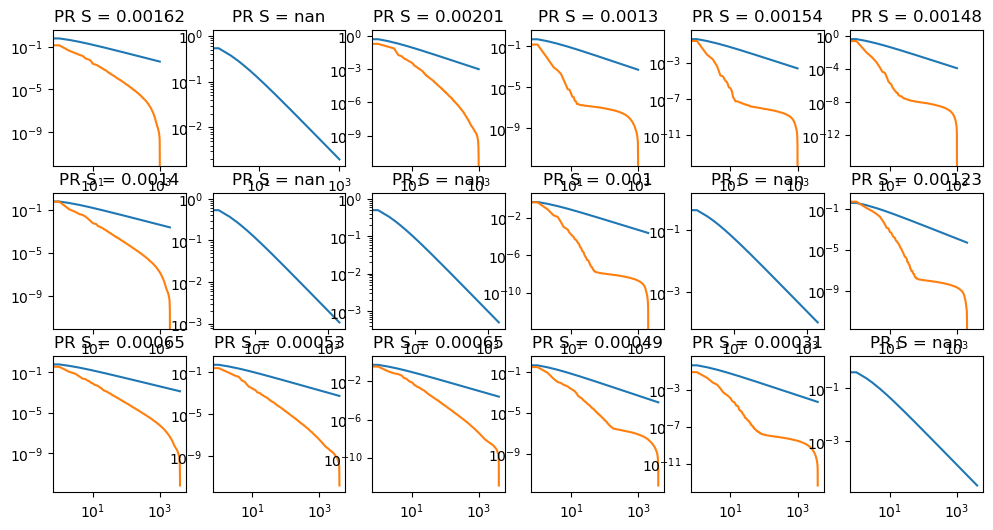

In [11]:
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
for i in range(3):
    for j in range(6):
        N = configs_array['N'][i]
        beta = configs_array['beta'][j]
        D = (np.arange(1, N+1)/N)**(-beta)
        S = results_array[i,j,0,0,:]
        ax[i,j].plot(D/D[0])
        ax[i,j].plot(S/S[0])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        if True:
            PR_D = D.sum()**2/(D**2).sum()/N
            PR_S = S.sum()**2/(S**2).sum()/N
            ax[i,j].set_title('PR S = {}'.format(np.round(PR_S, 5)))

In [24]:
def compute_psi_dim(g, PR_G, PR_D):

    ### --- Compute single-unit properties
    T_window = 100
    dT = 0.05
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    lags = np.arange(0, T_window, dT)
    n_lags = int(T_window/dT)
    lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)

    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for LDRG network
    num = 1 + (1/PR_D + 1/PR_G - 1)*np.abs(2*np.pi*g**2 * S_phi_S_phi)**2
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
    Psi_tau_tau = np.diag(Psi_tau1_tau2)
    
    return C_Phi_half[0]**2/(C_Phi_half[0]**2 + np.amax(np.abs(Psi_tau_tau)))

In [37]:
beta_approx, beta = get_exact_beta_for_PR(0.5)
G = (np.arange(1, N+1)/N)**beta

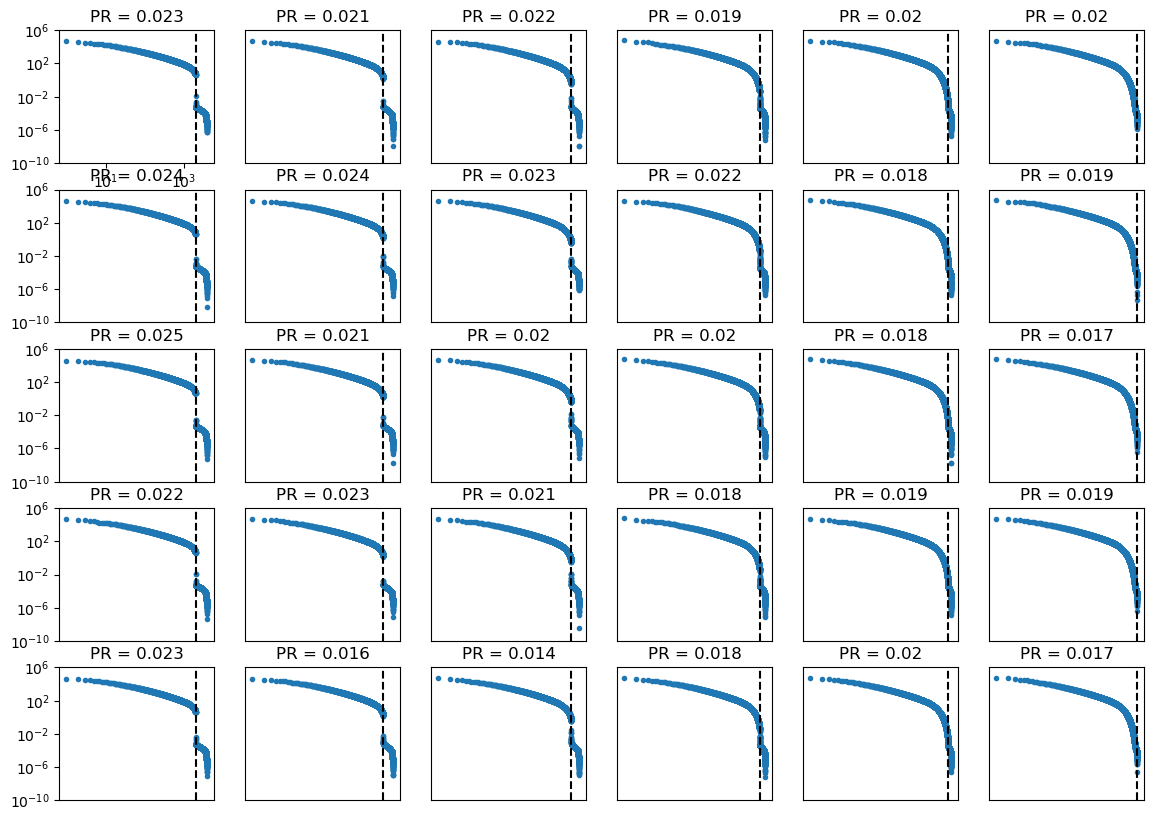

In [41]:
fig, ax = plt.subplots(5, 6, figsize=(14, 10))
#fig.suptitle('g = 20, PR theory = {}'.format(np.round(compute_psi_dim(20, 0.5, 1), 4)))
for i in range(6):
    for j in range(5):
        s = results_array[i,j,0]
        alpha = 1/(2 - configs_array['PR_D_PR_G'][i])
        ax[j,i].plot(s, '.', color='C0')
        ax[j,i].axvline(x=int(alpha*4000), color='k', linestyle='--')
        ax[j,i].set_xscale('log')
        ax[j,i].set_yscale('log')
        ax[j,i].set_ylim([1e-10, 1e6])
        if i > 0:
            ax[j,i].set_yticks([])
        if j > 0 or i > 0:
            ax[j,i].set_xticks([])
        PR = (s.sum())**2/(s**2).sum()/4000
        ax[j,i].set_title('PR = {}'.format(np.round(PR, 3)))

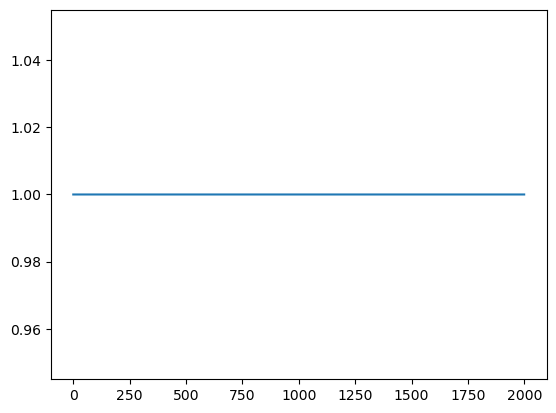

In [42]:
plt.plot(D)

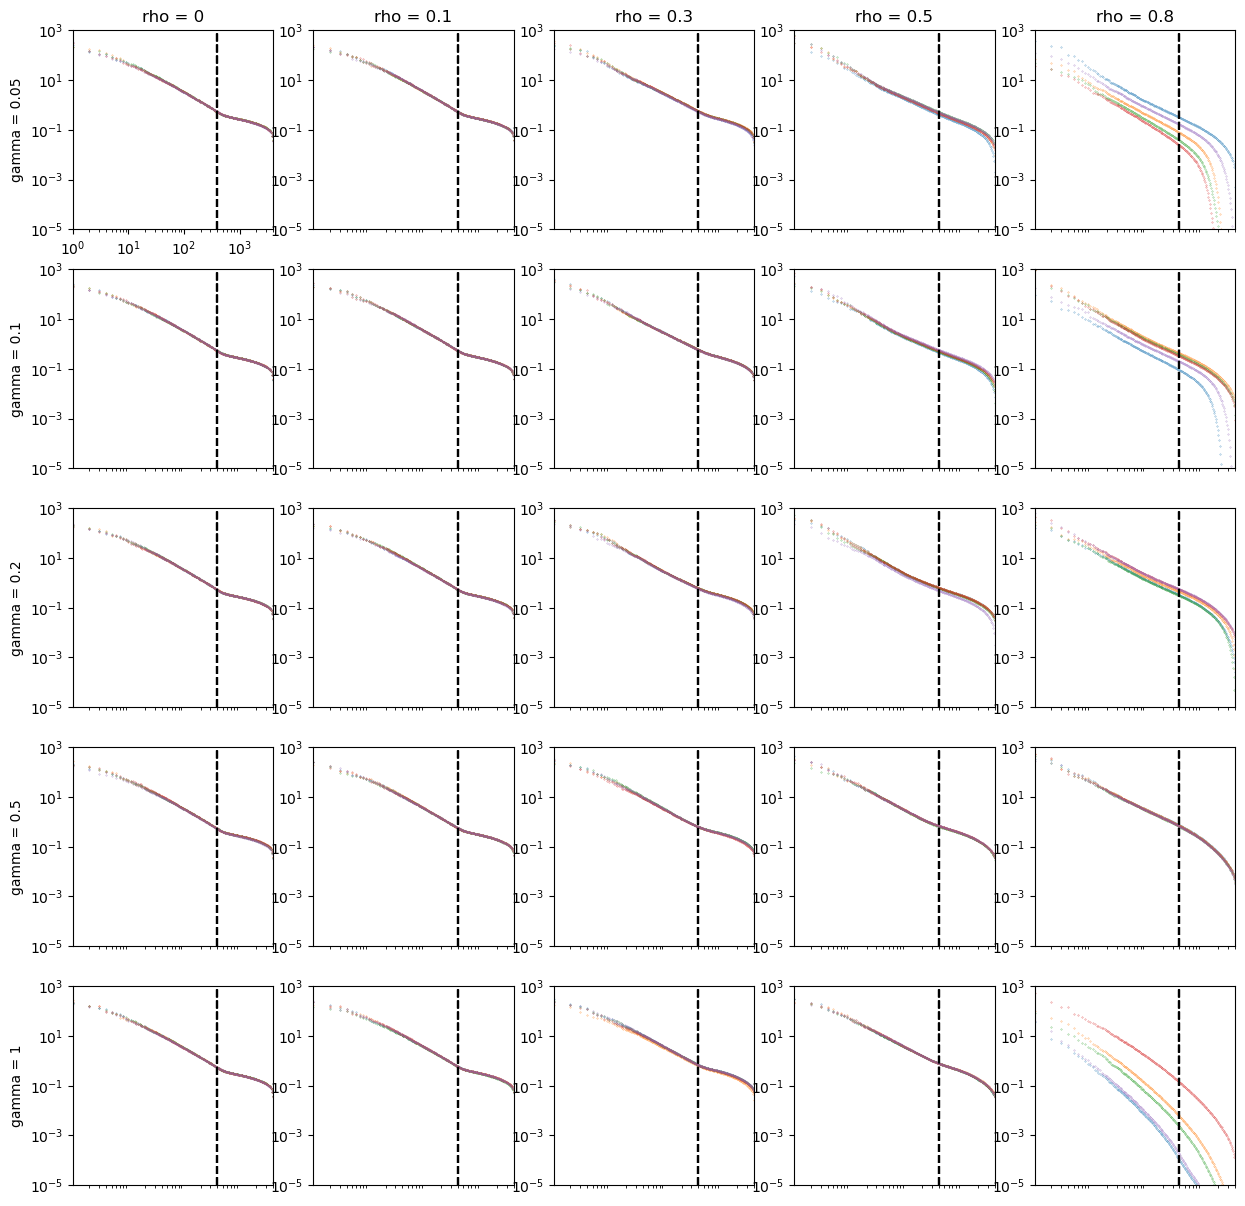

In [7]:
n_x, n_y, n_seed, _, N = results_array.shape
fig, ax = plt.subplots(n_x, n_y, figsize=(15, 15))
l = 0
idx = np.logspace(0, np.log10(N), 300).astype(int)
idx = np.array(sorted(list(set(idx)))) - 1
for i in range(n_x):
    for j in range(n_y):
        for k in range(n_seed):
            if i == 0:
                ax[i,j].set_title('rho = {}'.format(np.round(configs_array[key_order[1]][j], 2)))
            if j == 0:
                ax[i,j].set_ylabel('gamma = {}'.format(np.round(configs_array[key_order[0]][i],2)))
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,l,:]
            N_cutoff = int(0.1*N)
            ax[i,j].plot(idx, s[idx], '.', color='C{}'.format(k), alpha=0.8, markersize=0.5)
            ax[i,j].set_ylim([0.00001, 1000])
            ax[i,j].set_xlim([1, N])
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            if i !=0 or j != 0:
                ax[i,j].set_xticks([])
            ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')
    #ax[0,0].legend(['Cov spec', '_fits', 'PRV'])
#fig.savefig('figs/LDRG_zscored_spec.pdf')

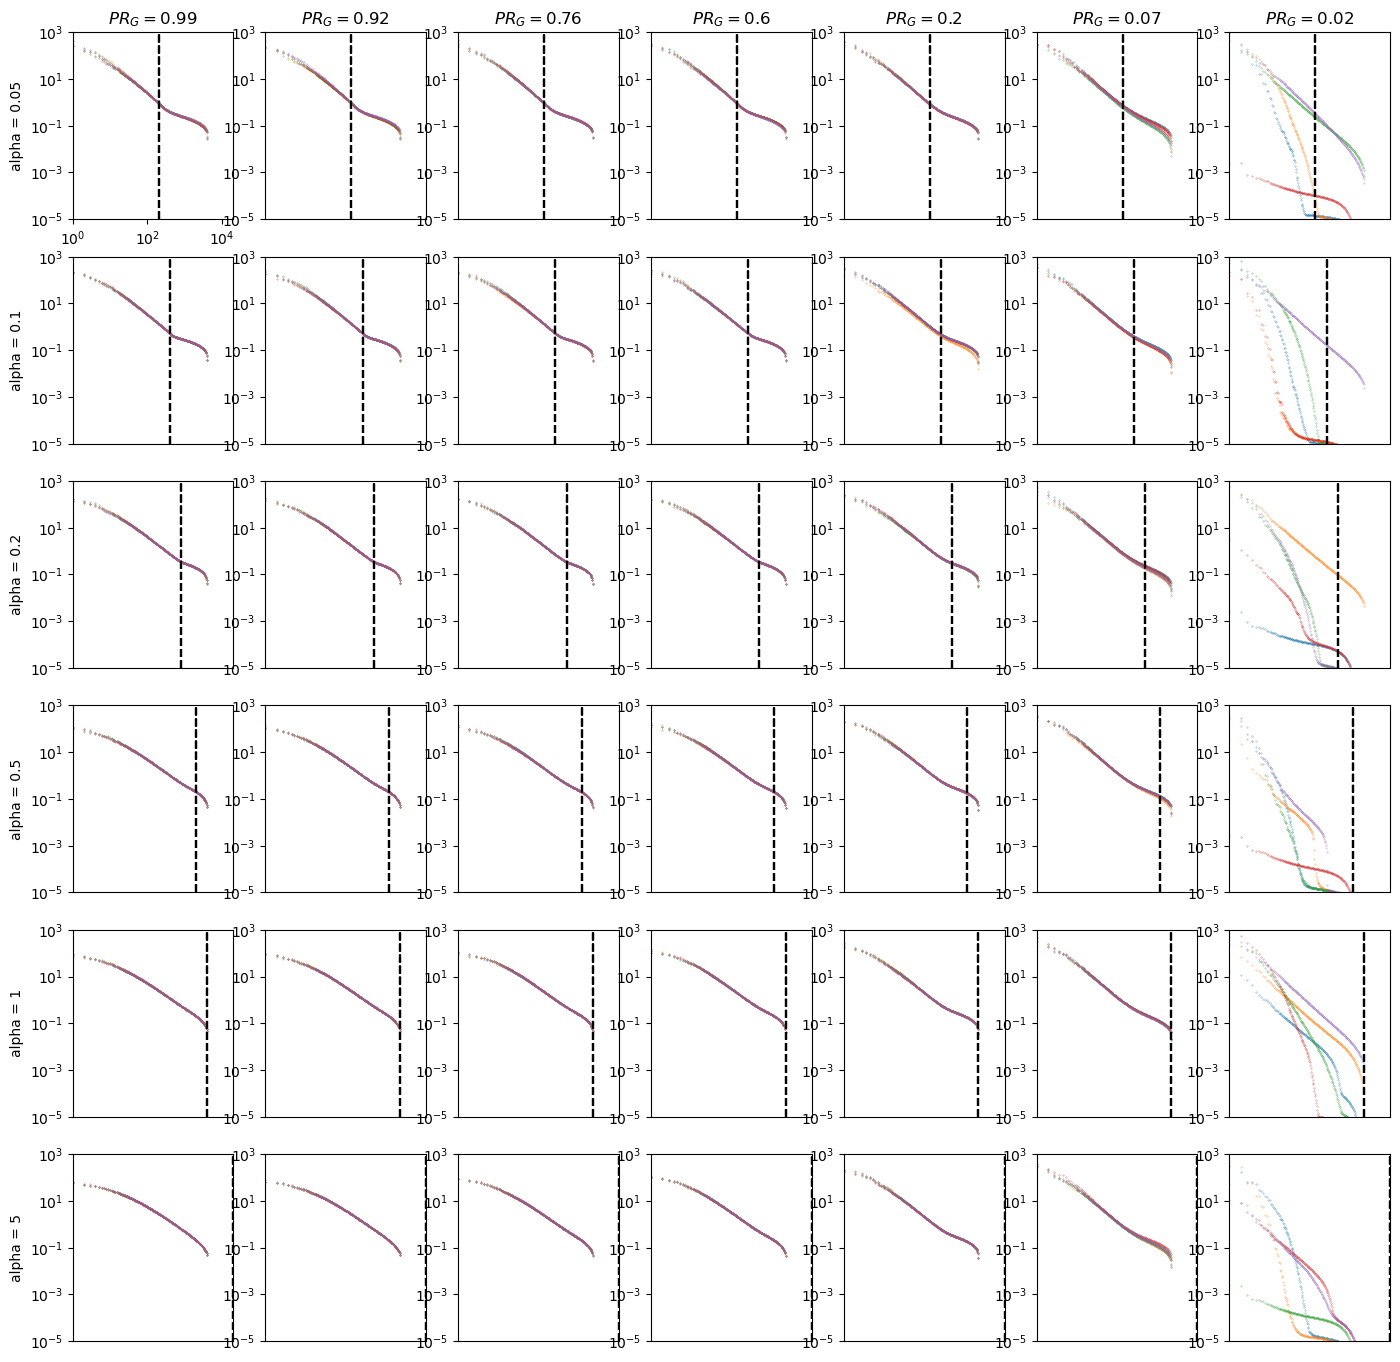

In [33]:
fig, ax = plt.subplots(6, 7, figsize=(17, 17))
N = 4000
l = 0
idx = np.logspace(0, np.log10(N), 300).astype(int)
idx = np.array(sorted(list(set(idx)))) - 1
for i in range(6):
    for j in range(7):
        for k in range(5):
            if i == 0:
                G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
                PR_G = np.sum(G)**2 / np.sum(G**2) / N
                ax[i,j].set_title('$PR_G = {}$'.format(np.round(PR_G, 2)))
            if j == 0:
                ax[i,j].set_ylabel('alpha = {}'.format(np.round(configs_array['alpha'][i],2)))
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,l,:]
            N_cutoff = int(configs_array['alpha'][i]*N)
            ax[i,j].plot(idx, s[idx], '.', color='C{}'.format(k), alpha=0.8, markersize=0.5)
            ax[i,j].set_ylim([0.00001, 1000])
            ax[i,j].set_xlim([1, N*5])
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            if i !=0 or j != 0:
                ax[i,j].set_xticks([])
            ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')
    #ax[0,0].legend(['Cov spec', '_fits', 'PRV'])
fig.savefig('figs/LDRG_zscored_spec.pdf')

In [ ]:
### --- NUMERICAL FIT --- ###

